# dominating set

Set up calculations and store in EspressoDB

In [1]:
import matplotlib.pylab as plt
import seaborn as sns
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import graph_summary, experiment_summary, data_summary, insert_result, QUBO_to_Ising

from networkx import Graph
from networkx.algorithms.approximation import min_weighted_dominating_set

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

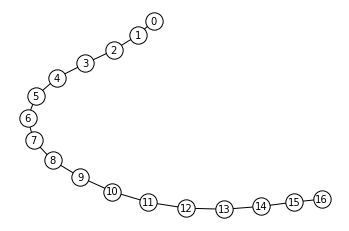

{'tag': 'NN(17)',
 'total_vertices': 17,
 'total_edges': 16,
 'max_edges': 2,
 'adjacency': [[0, 1],
  [1, 2],
  [7, 8],
  [6, 7],
  [10, 11],
  [4, 5],
  [5, 6],
  [12, 13],
  [11, 12],
  [13, 14],
  [8, 9],
  [9, 10],
  [15, 16],
  [2, 3],
  [14, 15],
  [3, 4]],
 'adjacency_hash': '5abf15d0e3345aefcebcec097ec71647'}

In [132]:
# Define Adjacency matrix
# Hamming(d,q)
# NN(v): 1D nearest neighbor with v vertices. max is 16 before minor embedding starts breaking
tag = "NN(17)"
#graph = gt.generate_hamming_graph(3, 3)
graph = {(0, 1), (1, 2), (2, 3), (3, 4), (4, 5),
         (5, 6), (6, 7), (7, 8), (8, 9), (9, 10),
         (10, 11), (11, 12), (12, 13), (13, 14),
        (14, 15), (15, 16)}
penalty = 2

directed = False
qubo = get_mds_qubo(graph, directed=directed, penalty = penalty, triangularize=True, dtype="d")

q_min = np.array(list(qubo.values())).min()

gt.get_plot(graph, directed=directed)
plt.show()
graph_params = graph_summary(tag, graph)
graph_params

In [133]:
J, h, C = QUBO_to_Ising(qubo.todense().tolist())
maxJ = max(abs(J).flatten())
maxh = max(abs(h))
print("Initial")
print(f"max(J) = {maxJ}")
print(f"max(h) = {maxh}")
print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
print("Must scale QUBO to these ranges\n")
fact = max([maxJ, maxh/2]) * 1.2
qubo = qubo / fact

J, h, C = QUBO_to_Ising(qubo.todense().tolist())
maxJ = max(abs(J).flatten())
maxh = max(abs(h))
print("Rescaled")
print(f"max(J) = {maxJ}")
print(f"max(h) = {maxh}")
print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
print("Must scale QUBO to these ranges")

Initial
max(J) = 2.0
max(h) = 5.5
DWave J_range = [-1.0, 1.0] 
DWave h_range = [-2.0, 2.0]
Must scale QUBO to these ranges

Rescaled
max(J) = 0.6060606060606061
max(h) = 1.6666666666666667
DWave J_range = [-1.0, 1.0] 
DWave h_range = [-2.0, 2.0]
Must scale QUBO to these ranges


In [134]:
classical_search(qubo)

This search will execute 562949953421312 iterations. Continue (y/n)?n


KeyboardInterrupt: Too many iterations abort.

In [135]:
# DWave settings
dwave_config = {
    "annealing_time": 200,  # integer microseconds [1, 2000]
    "answer_mode": "raw",
    "auto_scale": False,
    "num_reads": 1000,  # raw will dump out all results
    "num_spin_reversal_transforms": 0,  # ask Travis what this is
    "readout_thermalization": 0, # default 0
    "programming_thermalization": 1000, # default 1000
}
solver = "DW_2000Q_5"

experiment_params = experiment_summary(machine=solver, settings=dwave_config, penalty=penalty, factor=fact, qubo=qubo)

/Users/ithems/Scripts/quantum_linear_programming/qlp/mds/mds_qlpdb.py:91: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  norm_params = pd.io.json.json_normalize(params, sep="_").to_dict()


In [137]:
# Solve on DWave and push to database
sampler = DWaveSampler(solver=solver)
embed = EmbeddingComposite(sampler)
qubo_dict = {key: val for key, val in zip(qubo.keys(), qubo.values())}
for idx in range(10):
    print(idx)
    result = embed.sample_qubo(qubo_dict, **dwave_config)
    raw = result.to_pandas_dataframe()
    data_params = data_summary(raw, graph_params, experiment_params)
    result = insert_result(graph_params, experiment_params, data_params)
print(raw.sort_values("energy", ascending=True))

0
1
2
3
4
5
6


ValueError: no embedding found

In [138]:
print(raw.sort_values("energy", ascending=True))

     0  1  2  3  4  5  6  7  8  9  ...  42  43  44  45  46  47  48  \
745  0  1  0  0  0  1  1  0  1  1  ...   1   0   1   0   0   0   0   
5    1  0  0  1  0  1  1  1  1  0  ...   0   0   0   0   0   0   0   
219  0  1  0  0  1  1  0  0  1  1  ...   0   0   0   0   0   0   0   
912  0  1  0  0  1  1  0  0  1  1  ...   0   0   0   0   0   0   0   
4    0  1  0  0  1  1  0  0  1  1  ...   0   0   0   0   0   0   0   
..  .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..   
523  1  1  1  1  1  1  0  0  0  1  ...   0   1   0   1   1   0   0   
599  1  0  1  0  1  1  0  0  0  1  ...   0   1   0   1   0   0   0   
623  0  1  0  1  1  1  0  0  0  1  ...   0   1   0   1   0   0   0   
197  1  0  0  0  1  1  0  0  0  1  ...   1   0   0   1   1   0   0   
432  1  0  0  0  1  1  0  0  0  1  ...   0   0   0   0   0   0   0   

     chain_break_fraction    energy  num_occurrences  
745              0.040816 -7.272727                1  
5                0.020408 -6.969697              